<a href="https://colab.research.google.com/github/danielsaggau/causal-dyna-fair/blob/master/playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ecreager/causal-dyna-fair.git

Cloning into 'causal-dyna-fair'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 85 (delta 27), reused 42 (delta 5), pack-reused 0
Unpacking objects: 100% (85/85), done.


In [ ]:
%cd causal-dyna-fair
import os
import pickle
import sys
from typing import Dict

from absl import app
from absl import flags
import gin
import torch
import structural_eqns as se
from utils.policy import get_policy
from utils.data import get_data_args

[Errno 2] No such file or directory: 'causal-dyna-fair'
/content/causal-dyna-fair


In [ ]:
class OneStepSimulation:
    """Runs simulation for one step of dynamics under Liu et al 2018 SCM."""
    def __init__(self,
                 f_A: se.StructuralEqn,  # stochastic SE for group membership
                 f_X: se.StructuralEqn,  # stochastic SE for indiv scores
                 f_Y: se.StructuralEqn,  # stochastic SE for potential repayment
                 f_T: se.StructuralEqn,  # SE for threshold loan policy
                 f_Xtilde: se.StructuralEqn,  # SE for indiv score change
                 f_u: se.StructuralEqn,  # SE for individual utility
                 f_Umathcal: se.StructuralEqn,  # SE for avg instit. utility
                 f_Deltaj: se.StructuralEqn,  # SE per-group avg score change
                 ) -> None:
        self.f_A = f_A
        self.f_X = f_X
        self.f_Y = f_Y
        self.f_T = f_T
        self.f_Xtilde = f_Xtilde
        self.f_u = f_u
        self.f_Deltaj = f_Deltaj
        self.f_Umathcal = f_Umathcal

In [ ]:
   def run(self, num_steps: int, num_samps: int) -> Dict:
        """Run simulation forward for num_steps and return all observables."""
        if num_steps != 1:
            raise ValueError('Only one-step dynamics are currently supported.')
        blank_tensor = torch.zeros(num_samps)
        A = self.f_A(blank_tensor)
        X = self.f_X(A)
        Y = self.f_Y(X, A)
        T = self.f_T(X, A)
        Xtilde = self.f_Xtilde(X, Y, T)
        u = self.f_u(Y, T)
        Deltaj = self.f_Deltaj(X, Xtilde, A)
        Umathcal = self.f_Umathcal(u)
        return_dict = dict(
            A=A,
            X=X,
            Y=Y,
            T=T,
            u=u,
            Xtilde=Xtilde,
            Deltaj=Deltaj,
            Umathcal=Umathcal,
            )
        return return_dict

In [ ]:
    def intervene(self, **kwargs):
        """Update attributes via intervention."""
        for k, v in kwargs.items():
            setattr(self, k, v)

In [ ]:
def main(unused_argv):
    """Produces figures from Liu et al 2018 and save results."""
    del unused_argv
    gin.parse_config_files_and_bindings([FLAGS.gin_file], FLAGS.gin_param)

    seed = gin.query_parameter('%seed')
    results_dir = gin.query_parameter('%results_dir')
    results_dir = os.path.normpath(results_dir)
    num_steps = gin.query_parameter('%num_steps')
    num_samps = gin.query_parameter('%num_samps')
    utility_repay = gin.query_parameter('%utility_repay')
    utility_default = gin.query_parameter('%utility_default')
    score_change_repay = gin.query_parameter('%score_change_repay')
    score_change_default = gin.query_parameter('%score_change_default')
    
    torch.manual_seed(seed)
    inv_cdfs, loan_repaid_probs, pis, group_size_ratio, scores_list, _ = \
            get_data_args()
    import pdb
    pdb.set_trace()

    utils = (utility_default, utility_repay)
    impact = (score_change_default, score_change_repay)
    prob_A_equals_1 = group_size_ratio[-1]
    f_A = se.IndivGroupMembership(prob_A_equals_1)
    f_X = se.InvidScore(*inv_cdfs)
    f_Y = se.RepayPotentialLoan(*loan_repaid_probs)
    f_T = get_policy(loan_repaid_probs, pis, group_size_ratio, utils, impact,
                     scores_list)
    f_Xtilde = se.ScoreUpdate(*impact)
    f_u = se.InstitUtil(*utils)
    f_Umathcal = se.AvgInstitUtil()
    f_Deltaj = se.AvgGroupScoreChange() 

    simulation = OneStepSimulation(
f_A, f_X, f_Y, f_T, f_Xtilde, f_u, f_Umathcal, f_Deltaj,
        )
    results = simulation.run(num_steps, num_samps)
    policy_name = gin.query_parameter('%policy_name')
    situation = 'situation1' if (utility_default == -4) else 'situation2'
    these_thresholds = {
        situation:
        {policy_name: [f_T.threshold_group_0, f_T.threshold_group_1]}
    }
    results['threshes'] = these_thresholds

   # Finally, write results to disk
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # for reproducibility, copy command and script contents to results
    if results_dir not in ('.', ):
        cmd = 'python ' + ' '.join(sys.argv)
        with open(os.path.join(results_dir, 'command.sh'), 'w') as f:
            f.write(cmd)
        file_basename = os.path.basename(__file__)
        this_script = open(__file__, 'r').readlines()
        with open(os.path.join(results_dir, file_basename), 'w') as f:
            f.write(''.join(this_script))

    results_filename = os.path.join(results_dir, 'results.p')
    with open(results_filename, 'wb') as f:
        _ = pickle.dump(results, f)

    # Finally, write gin config to disk
    with open(os.path.join(results_dir, 'config.gin'), 'w') as f:
        f.write(gin.operative_config_str())

if __name__ == "__main__":
    FLAGS = flags.FLAGS
    flags.DEFINE_string(
        'gin_file', './config/simulation.gin', 'Path of config file.')
    flags.DEFINE_multi_string(
        'gin_param', None, 'Newline separated list of Gin parameter bindings.')

    app.run(main)

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 104 kB 8.8 MB/s 
     |████████████████████████████████| 48 kB 7.0 MB/s 
     |████████████████████████████████| 283 kB 67.4 MB/s 
     |████████████████████████████████| 156 kB 74.4 MB/s 
     |████████████████████████████████| 829 kB 62.6 MB/s 
     |████████████████████████████████| 44 kB 3.0 MB/s 
     |████████████████████████████████| 1.6 MB 46.0 MB/s 
     |████████████████████████████████| 119 kB 77.6 MB/s 
     |████████████████████████████████| 785 kB 80.8 MB/s 
     |████████████████████████████████| 121 kB 75.3 MB/s 
     |████████████████████████████████| 1.4 MB 65.4 MB/s 
     |████████████████████████████████| 300 kB 62.1 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 107 kB 65.5 MB/s 
     |████████████████████████████████| 83 kB 2.3 MB/s 
     |████████████████████████████████| 88 kB 9.3 MB/s 
     |████████████████████████████████| 648 kB 79.7 MB/s 
     |███████████████████

In [ ]:
!sh ./bin/icml_results.sh

In [ ]:
!git clone https://github.com/zykls/whynot.git
%cd whynot
!pip install .

Cloning into 'whynot'...
remote: Enumerating objects: 828, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 828 (delta 23), reused 23 (delta 10), pack-reused 769
Receiving objects: 100% (828/828), 12.06 MiB | 11.50 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/whynot
Processing /content/whynot
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 668 kB 10.1 MB/s 
     |████████████████████████████████| 9.1 MB 53.6 MB/s 
     |████████████████████████████████| 5.4 MB 20.1 MB/s 
     |████████████████████████████████| 62 kB 562 kB/

In [ ]:
import whynot.gym as gym

env = gym.make('Credit-v0')
env.seed(1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[1]

In [ ]:
observation = env.reset()
for _ in range(100):
    action = env.action_space.sample()  # Replace with your treatment policy
    observation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import whynot as wn
import whynot.gym as gym

%matplotlib inline

In [ ]:
%cd /content/whynot/examples/reinforcement_learning/
import scripts as utils

/content/whynot/examples/reinforcement_learning


In [ ]:
"""Utility functions used by all of the simulators."""
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
import copy
import itertools

import numpy as np
from tqdm.auto import tqdm

import whynot as wn


def pretty_print(experiment, dataset, results):
    """Print the results of running the causal suite on data from an experiment.

    Parameters
    ----------
        experiment: `whynot.dynamics.DynamicsExperiment` or `whynot.framework.GenericExperiment`
            Experiment object used to generate the causal dataset
        dataset: `whynot.framework.Dataset`
            Dataset object passed to the causal suite.
        results:    dict
            Dictionary of results returned running `whynot.causal_suite` on the dataset

    """
    print("Name: ", experiment.name)
    print("Description: ", experiment.description)
    for method, estimate in results.items():
        print(f"Method: {method:<25} \t\t Estimate: {estimate.ate:2.2e}")
    print(f"{' ':<30} \t\t\t Ground Truth: {dataset.sate:2.2e}")


def parallelize(func, arg_lst, show_progress=False, max_workers=None):
    """Parallel execution of function func across a list of arguments.

    The function func and all of the arguments must be pickable. Func is
    executed on each elements of arg_list as func(*args)

    Parameters
    ----------
        func:
            Function to repeatedly execute, must be pickable.
        arg_lst: iterable
            Iterator of unnamed arguments. Each element arg is passed as func(*arg).
        show_progress: bool
            Whether or not to display a progress bar.
        max_workers: int
            Maximum number of parallel processes to execute simultaneously.

    Returns
    -------
        results: list
            List of outcomes of running func(*arg) on each arg in arg_list.
            Results are in the same order as the input arg_list.

    """

    def display(range_obj):
        if show_progress:
            range_obj = tqdm(range_obj)
        return range_obj

    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for args in arg_lst:
            futures.append(executor.submit(func, *args))
        for future in display(futures):
            data = future.result()
            results.append(data)
    return results


def parallel_run_estimators(causal_datasets):
    """Run causal suite in parallel for repeated trials of a causal experiment.

    Parameters
    ----------
        causal_datasets: dict
            Dictionary mapping an experiment setting to a list of datasets
            representing repeated trials of the experiment.

    Returns
    -------
        all_estimates: dict
            Dictionary mapping estimators name and experimental setting
            to a list of `wn.InferenceResult` objects for each trial,
            e.g. all_estimates['ols'][200][3] is the InferenceResult for ols
            on the 3rd trial of the experiment with setting 200.

    """
    all_estimates = defaultdict(lambda: defaultdict(list))
    for key, trials in causal_datasets.items():
        parallel_args = [
            (dataset.covariates, dataset.treatments, dataset.outcomes)
            for dataset in trials
        ]
        all_trial_estimates = parallelize(
            wn.causal_suite, parallel_args, show_progress=True
        )
        for estimates in all_trial_estimates:
            for method, estimate in estimates.items():
                all_estimates[method][key].append(estimate)
    return all_estimates


def sample_size_experiment(
    experiment, sample_sizes, num_trials, parameters=None, seeds=None, verbose=False
):
    """Repeatedly run an experiment at different sample sizes.

    All of the datasets are generate sequentially, and the estimators are run in
    parallel.

    Parameters
    ----------
        experiment: `whynot.dynamics.DynamicsExperiment` or `whynot.framework.GenericExperiment`
            Instantiated experiment object.
        sample_sizes: list
            List of sample sizes to run the experiment
        num_trials: int
            How many trials to run each experiment for a fixed sample size.
        parameters: dict
            Dictionary of {param_name: param_value} fixing non-varying parameters
            for the experiment.
        (optional) seeds: list
           List of random seeds to use for each trial. If specified, should have
           length num_trials.
        (optional) verbose: bool
            Print status updates.

    Returns
    -------
        estimates: dict
            Dictionary mapping each method to a dictionary of sample_size to
            `whynot.framework.InferenceResults` for each trial at the given
            sample size.

                estimates[method_name] = {
                    sample_size1: [estimates_for_sample_size_1],
                    sample_size2: [estimates_for_sample_size_2],
                    ...}

        sample_ates: dict
            Dictionary mapping sample_size to the sample_ate for each trial.

                sample_ates = {
                    sample_size1: [sample_ates_for_sample_size_1],
                    sample_size2: [sample_ates_for_sample_size_2],
                    ...}

    """
    if seeds is None:
        seeds = [None] * num_trials
    assert len(seeds) == num_trials
    if parameters is None:
        parameters = {}

    if verbose:
        print("Generating causal datasets...")
    datasets = defaultdict(list)
    all_sates = defaultdict(list)
    for (sample_size, seed) in itertools.product(sample_sizes, seeds):
        dataset = experiment.run(num_samples=sample_size, seed=seed, **parameters)
        all_sates[sample_size].append(dataset.sate)
        datasets[sample_size].append(dataset)

    if verbose:
        print("Running estimators...")
    return parallel_run_estimators(datasets), all_sates


def parameter_sweep_experiment(
    experiment,
    sample_size,
    num_trials,
    parameter_name,
    parameter_values,
    fixed_parameters=None,
    seeds=None,
    verbose=False,
):
    """Repeatedly run an experiment for different values of a parameter.

    All of the datasets are generate sequentially, and the estimators are run in
    parallel.

    Parameters
    ----------
        experiment: `whynot.dynamics.DynamicsExperiment` or `whynot.framework.GenericExperiment`
            Instantiated experiment object.
        sample_size: int
            Sample size to use for all experiments.
        num_trials: int
            How many trials to run each experiment for a fixed parameter setting.
        parameter_name: str
            Name of the parameter to vary.
        parameter_values: list
            List of values of the parameter to vary
        fixed_parameters: dict
            Dictionary of {param_name: param_value} fixing non-varying parameters
            for the experiment.
        (optional) seeds: list
           List of random seeds to use for each trial. If specified, should have
           length num_trials.
        (optional) verbose: bool
            Print status updates.

    Returns
    -------
        estimates: dict
            Dictionary mapping each method to a dictionary of parameter_value to
            `whynot.framework.InferenceResults` for each trial at the given
            sample size.

                estimates[method_name] = {
                    parameter_value1: [estimates_for_parameter_value1],
                    parameter_value2: [estimates_for_parameter_value2],
                    ...}

        sample_ates: dict
            Dictionary mapping parameter_value to the sample_ate for each trial.

    """
    if seeds is None:
        seeds = [None] * num_trials
    assert len(seeds) == num_trials
    if fixed_parameters is None:
        fixed_parameters = {}

    if verbose:
        print("Generating causal datasets...")
    datasets = defaultdict(list)
    sample_ates = defaultdict(list)
    for (parameter_value, seed) in itertools.product(parameter_values, seeds):
        parameters = copy.deepcopy(fixed_parameters)
        parameters[parameter_name] = parameter_value
        dataset = experiment.run(num_samples=sample_size, seed=seed, **parameters)
        sample_ates[parameter_value].append(dataset.sate)
        datasets[parameter_value].append(dataset)
    if verbose:
        print("Running estimators...")
    return parallel_run_estimators(datasets), sample_ates


def summarize_errors(estimates, sample_ates, metric):
    """Summarize estimator errors for a parameter or sample size sweep.

    Currently, this function only supports summaries for ATE estimation.
    This function should be used in conjunction with parameter_sweep_experiment
    and sample_size_experiment.

    Parameters
    ----------
        estimates: dict
            Dictionary mapping method_names to a dictionary of experiment
            settings and `whynot.InferenceResults` as returned by
            parameter_sweep_experiment.
        sample_ates: dict
            Dictionary mapping experiment settings to sample ates.
        metric: str
            One of 'relative_error' or 'absolute_error' for reporting results.

    Returns
    -------
        summary: dict
            Dictionary mapping method name to a tuple of (means, stds), where
            means is a list of mean error for each experimental setting, and
            similarly for standard deviation.

    """

    def score(est, sate):
        if metric == "relative_error":
            return np.abs((est - sate) / sate)

        if metric == "absolute_error":
            return np.abs(est - sate)

        raise NotImplementedError

    summary = {}
    for method, results in estimates.items():
        means, stds = [], []
        for setting, inferences in results.items():
            scores = []
            for inference, sample_ate in zip(inferences, sample_ates[setting]):
                scores.append(score(inference.ate, sample_ate))
            means.append(np.mean(scores))
            stds.append(np.std(scores) / np.sqrt(len(scores)))
        summary[method] = (means, stds)
    return summary


In [ ]:
base_dataset = env.initial_state.values()
base_features, base_labels = base_dataset["features"], base_dataset["labels"]
num_agents, num_features = base_features.shape
print(f"The dataset has {num_agents} agents and {num_features} features.")

IndexError: ignored

In [ ]:
l2_penalty = 1.0 / num_agents
baseline_theta = utils.fit_logistic_regression(base_features, base_labels, l2_penalty)
baseline_acc = ((base_features.dot(baseline_theta) > 0)  == base_labels).mean()
print(f"Baseline logistic regresion model accuracy: {100 * baseline_acc:.2f}%")

NameError: ignored

In [ ]:
!git clone https://github.com/zykls/whynot.git
%cd whynot
!pip install -r requirements.txt

In [ ]:
import whynot.gym as gym
env = gym.make('HIV-v0')
env.seed(1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[1]

In [ ]:
observation = env.reset()
for _ in range(100):
    action = env.action_space.sample()  # Replace with your treatment policy
    observation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()

In [ ]:
class NoTreatmentPolicy(utils.Policy):
    """The policy of always no treatment."""
    def __init__(self):
        super(NoTreatmentPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return 0
    
class MaxTreatmentPolicy(utils.Policy):
    """The policy of always applying both RT inhibitor and protease inhibitor."""
    def __init__(self):
        super(MaxTreatmentPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return 3
    
class RandomPolicy(utils.Policy):
    """The policy of picking a random action at each time step."""
    def __init__(self):
        super(RandomPolicy, self).__init__(env)
    
    def sample_action(self, obs):
        return np.random.randint(4)

In [ ]:
learned_policy = utils.run_training_loop(
    env=env, n_iter=300, max_episode_length=100, batch_size=1000, learning_rate=1e-3)

# Credit simulation


In [1]:
!pip install whynot

     |████████████████████████████████| 7.5 MB 11.1 MB/s 
     |████████████████████████████████| 5.4 MB 18.1 MB/s 
     |████████████████████████████████| 668 kB 60.8 MB/s 
     |████████████████████████████████| 9.1 MB 41.2 MB/s 
     |████████████████████████████████| 62 kB 599 kB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 


In [2]:
import matplotlib.pylab as plt
from tqdm.auto import tqdm

import whynot as wn
import whynot.traceable_numpy as np

from whynot.simulators.delayed_impact.simulator import INV_CDFS, GROUP_SIZE_RATIO

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install whynot

In [3]:
def sample_initial_states(rng):
    group = int(rng.uniform() < GROUP_SIZE_RATIO[1])
    # Compute credit score via inverse CDF trick
    score = INV_CDFS[group](rng.uniform())
    return wn.delayed_impact.State(group=group, credit_score=score)

In [4]:
@wn.parameter(
    name="threshold_g0", default=550, description="Lending threshold for group 0")
@wn.parameter(
    name="threshold_g1", default=550, description="Lending threshold for group 1")
def construct_config(threshold_g0, threshold_g1):
    """Return the experimental config for runs without intervention"""
    return wn.delayed_impact.Config(
        start_time=0, end_time=1, threshold_g0=threshold_g0, threshold_g1=threshold_g1
    )

In [5]:
def extract_outcomes(run):
    # Recall states are individuals in this model
    agent_t0 = run.states[0]
    agent_t1 = run.states[1]
    return [agent_t1.credit_score - agent_t0.credit_score, agent_t1.profits]

In [6]:
def creditscore_threshold(score):
    """Alternate credit bureau scoring policy."""
    return max(score, 600)

def intervention():
    return wn.delayed_impact.Intervention(credit_scorer=creditscore_threshold, time=0)

In [7]:
def extract_outcomes(run):
    # Recall states are individuals in this model
    agent_t0 = run.states[0]
    agent_t1 = run.states[1]
    return [agent_t1.credit_score - agent_t0.credit_score, agent_t1.profits]

In [8]:
def sample_initial_states(rng):
    group = int(rng.uniform() < GROUP_SIZE_RATIO[1])
    # Compute credit score via inverse CDF trick
    score = INV_CDFS[group](rng.uniform())
    return wn.delayed_impact.State(group=group, credit_score=score)

In [9]:
@wn.parameter(
    name="threshold_g0", default=550, description="Lending threshold for group 0")
@wn.parameter(
    name="threshold_g1", default=550, description="Lending threshold for group 1")
def construct_config(threshold_g0, threshold_g1):
    """Return the experimental config for runs without intervention"""
    return wn.delayed_impact.Config(
        start_time=0, end_time=1, threshold_g0=threshold_g0, threshold_g1=threshold_g1
    )

In [10]:
def extract_outcomes(run):
    # Recall states are individuals in this model
    agent_t0 = run.states[0]
    agent_t1 = run.states[1]
    return [agent_t1.credit_score - agent_t0.credit_score, agent_t1.profits]

In [11]:
def creditscore_threshold(score):
    """Alternate credit bureau scoring policy."""
    return max(score, 600)

def intervention():
    return wn.delayed_impact.Intervention(credit_scorer=creditscore_threshold, time=0)

In [12]:
CreditBureauExperiment = wn.DynamicsExperiment(
    name="CreditBureauExperiment",
    description="Intervention on the credit scoring mechanism.",
    simulator=wn.delayed_impact,
    simulator_config=construct_config,
    intervention=intervention,
    state_sampler=sample_initial_states,
    propensity_scorer=1.0,
    outcome_extractor=extract_outcomes,
    covariate_builder=lambda run: run.initial_state.group,
)

In [13]:
minority_thresholds = list(range(300, 800, 10))

average_min_score_changes = []
average_inst_profits = []
for tau_0 in tqdm(minority_thresholds):
    # Run the experiment to generate the dataset
    dataset = CreditBureauExperiment.run(threshold_g0=tau_0, num_samples=1000, parallelize=True)    
    
    # Only consider score changes for the minority group
    minority_locs = dataset.covariates[:, 0] == 0
    minority_treated_locs = minority_locs & (dataset.treatments == 1)

    score_changes = dataset.outcomes[:, 0]
    minority_changes = score_changes[minority_treated_locs]
    average_min_score_changes.append(np.mean(minority_changes))
        
    # Report profits over the entire group
    ind_profits = dataset.outcomes[:, 1][dataset.treatments == 1]
    average_inst_profits.append(np.mean(ind_profits))

  0%|          | 0/50 [00:00<?, ?it/s]

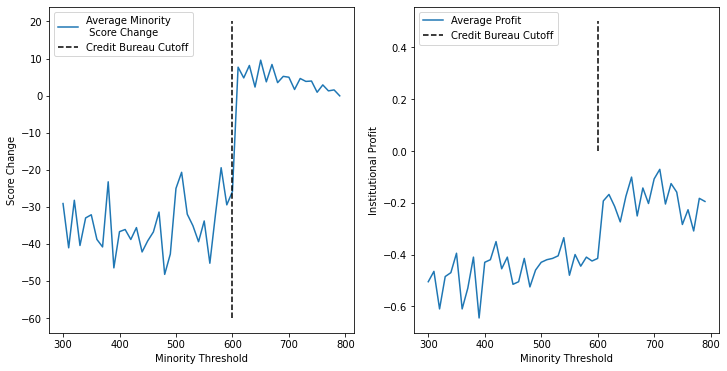

In [14]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(minority_thresholds, average_min_score_changes, label="Average Minority\n Score Change")
axs[0].plot([600] * 20, np.linspace(-60, 20, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[0].legend()
axs[0].set_xlabel("Minority Threshold")
axs[0].set_ylabel("Score Change")
axs[1].plot(minority_thresholds, average_inst_profits, label="Average Profit")
axs[1].plot([600] * 20, np.linspace(0, 0.5, 20), label="Credit Bureau Cutoff", linestyle="--", color="black")
axs[1].set_xlabel("Minority Threshold")
axs[1].set_ylabel("Institutional Profit")
axs[1].legend();

In [19]:
#utilz
def evaluate_logistic_loss(X, Y, theta, l2_penalty):
    """Compute the l2-penalized logistic loss function
    Parameters
    ----------
        X: np.ndarray
            A [num_samples, num_features] matrix of features. The last
            feature dimension is assumed to be the bias term.
        Y: np.ndarray
            A [num_samples] vector of binary labels.
        theta: np.ndarray
            A [num_features] vector of classifier parameters
        l2_penalty: float
            Regularization coefficient. Use l2_penalty=0 for no regularization.
    Returns
    -------
        loss: float
    """
    n = X.shape[0]

    logits = X @ theta
    log_likelihood = (
        1.0 / n * np.sum(-1.0 * np.multiply(Y, logits) + np.log(1 + np.exp(logits)))
    )

    regularization = (l2_penalty / 2.0) * np.linalg.norm(theta[:-1]) ** 2

    return log_likelihood + regularization

In [ ]:
# utilz
def fit_logistic_regression(X, Y, l2_penalty, tol=1e-7, theta_init=None):
    """Fit a logistic regression model via gradient descent.
    Parameters
    ----------
        X: np.ndarray
            A [num_samples, num_features] matrix of features.
            The last feature dimension is assumed to be the bias term.
        Y: np.ndarray
            A [num_samples] vector of binary labels.
        l2_penalty: float
            Regularization coefficient. Use l2_penalty=0 for no regularization.
        tol: float
            Stopping criteria for gradient descent
        theta_init: np.ndarray
            A [num_features] vector of classifier parameters to use a
            initialization
    Returns
    -------
        theta: np.ndarray
            The optimal [num_features] vector of classifier parameters.
    """
    X = np.copy(X)
    Y = np.copy(Y)
    n, d = X.shape

    # Smoothness of the logistic loss
    smoothness = np.sum(X ** 2) / (4.0 * n)

    # Optimal initial learning rate
    eta_init = 1 / (smoothness + l2_penalty)

    if theta_init is not None:
        theta = np.copy(theta_init)
    else:
        theta = np.zeros(d)

    # Evaluate loss at initialization
    prev_loss = evaluate_logistic_loss(X, Y, theta, l2_penalty)

    loss_list = [prev_loss]
    i = 0
    gap = 1e30

    eta = eta_init
    while gap > tol:

        # take gradients
        exp_tx = np.exp(X @ theta)
        c = exp_tx / (1 + exp_tx) - Y
        gradient = 1.0 / n * np.sum(
            X * c[:, np.newaxis], axis=0
        ) + l2_penalty * np.append(theta[:-1], 0)

        new_theta = theta - eta * gradient

        # compute new loss
        loss = evaluate_logistic_loss(X, Y, new_theta, l2_penalty)

        # do backtracking line search
        if loss > prev_loss:
            eta = eta * 0.1
            gap = 1e30
            continue

        eta = eta_init
        theta = np.copy(new_theta)

        loss_list.append(loss)
        gap = prev_loss - loss
        prev_loss = loss

        i += 1

    return theta

In [ ]:
def covariates_from_population(popu):
    """Create covariates from population of agents.
    The extracted covariates are:
        * sex (1 female, 0 male)
        * age (young, medium old)
        * old age 
        * maternal respobility
        *
        * citizenship 
        * education 
        * labor history 

    Parameters
    ----------
    popu : dict
        Dictionary specifying population of agents.
    Returns
    -------
    covariates: np.array
    """
    covariates = []
    for person in popu.values():
        covariates.append(
            [
                1 if person["sex"] == "f" else 0,
                1 if person["disability"] > 0 else 0,
                1 if person["maternal"] > 0 else 0,
                1 if person["partner"] > 0 else 0,
                1 if person["old_age"] == "yes" else 0,
                person["age"],
                person["labor_history"],
                1 if person["citizenship"] == "f" else 0,

            ]
        )

    return np.array(covariates)



In [ ]:
# regression
""""y - labour makret outcome outcome
    x - covariates 
    s - sensitive features""""



In [ ]:
# States 
""""
1 - positive outcome
0 - still unemployed 
""""

In [ ]:
# 